## VM setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/Master Thesis/Language Model Training"

/content/gdrive/MyDrive/Master Thesis/Language Model Training


In [ ]:
!pip install transformers==4.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 7.9 MB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
     |████████████████████████████████| 880 kB 71.6 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 6.6 MB 40.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1b4ba0c9df84063a63fb77d48dc41a5479b50f0d3a491e735bc18099a7b3410e
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 8.2 MB/s 
     |████████████████████████████████| 141 kB 68.0 MB/s 
     |████████████████████████████████| 212 kB 71.5 MB/s 
     |████████████████████████████████| 115 kB 64.7 MB/s 
     |████████████████████████████████| 127 kB 71.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


### Imports

In [ ]:
import sys
sys.path.insert(0, "/content/gdrive/MyDrive/Master Thesis/ModelFineTuning/")
from hub_token import HUB_TOKEN

In [ ]:
import torch
from torch import cuda
import transformers
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import TrainerCallback
import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from collections import ChainMap
import random
from tqdm import tqdm
import shutil
from datetime import datetime
import json
import os

In [ ]:
import multiprocessing

core_count = multiprocessing.cpu_count() # Count the number of cores in a computer
core_count

2

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

### Helper functions

In [ ]:
def moving_avg(mylist, N=5):
    try:
        shape = mylist.shape
        mylist = np.ravel(mylist)
    except AttributeError:
        shape = (1, -1)

    cumsum, moving_aves = [0], []

    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    diff = len(mylist) - len(moving_aves)
    if diff > 0:
        tmp = [0 for i in range(diff)]
        tmp.extend(moving_aves)
        moving_aves = tmp

    return np.asarray(moving_aves).reshape(shape)


## Choose model

### TwitchLeagueBert-500k like fu

In [ ]:
model_name = "Epidot/TwitchLeagueBert-500k-finetuned-highlight-detection"
dataset_name = "Epidot/private_fuetal2017_TwitchLeagueBert_highlights_preprocessed_oversampled"

### Roberta like fu

In [ ]:
model_name = "Epidot/roberta-base-finetuned-highlight-detection"
dataset_name = "Epidot/private_fuetal2017_highlights_preprocessed_oversampled"

## Load Tokenizer



In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

Downloading:   0%|          | 0.00/478 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/429k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Load data

In [ ]:
ds = datasets.load_dataset(dataset_name, use_auth_token=HUB_TOKEN)

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Using custom data configuration Epidot--private_fuetal2017_TwitchLeagueBert_highlights_preprocessed_oversampled-2568595d364d56f5


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Epidot___parquet/Epidot--private_fuetal2017_TwitchLeagueBert_highlights_preprocessed_oversampled-2568595d364d56f5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ds

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 128683
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 613062
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 106757
    })
})

In [ ]:
small_ds = datasets.Dataset.from_dict(ds["val"][5000:5500])

In [ ]:
# small_ds = ds["val"]

In [ ]:
small_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 106757
})

In [ ]:
flat_highlights = np.ravel(small_ds["labels"])

In [ ]:
"number of highlight chunks", sum(flat_highlights)

('number of highlight chunks', 11413.0)

In [ ]:
"total number of chunks", len(flat_highlights)

('total number of chunks', 106757)

In [ ]:
"ratio non-highlight / highlight", sum(flat_highlights)/len(flat_highlights)

('ratio non-highlight / highlight', 0.10690633869441817)

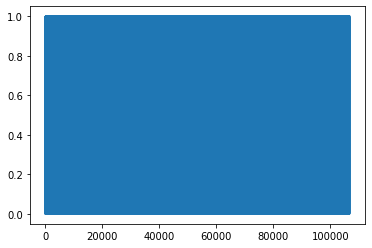

In [ ]:
plt.plot(list(range(len(flat_highlights))), flat_highlights)

## Load model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

In [ ]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

## Prediction

In [ ]:
input_ids = [(iid + [tokenizer.pad_token_id] * 128)[:128] for iid in  small_ds['input_ids']]
attention_mask = [(atm + [0] * 128)[:128] for atm in small_ds['attention_mask']]

In [ ]:
batch_size = 8

input_ids_batched = torch.IntTensor([input_ids[i:j] for i, j in zip(range(0,len(input_ids)-batch_size, batch_size), range(batch_size,len(input_ids), batch_size))]).to(device)
attention_mask_batched = torch.IntTensor([attention_mask[i:j] for i, j in zip(range(0,len(attention_mask)-batch_size, batch_size), range(batch_size,len(attention_mask), batch_size))]).to(device)

In [ ]:
preds = list()
model.eval()

with torch.no_grad():
  for i in tqdm(range(len(input_ids_batched))):
    iids, atm = input_ids_batched[i], attention_mask_batched[i]
    preds.append(model.forward(iids, atm))

100%|██████████| 13344/13344 [06:46<00:00, 32.79it/s]


## Ouput inspection

In [ ]:
res = list()
# flatten output
for p in preds:
  res.extend(torch.flatten(p["logits"]).tolist())

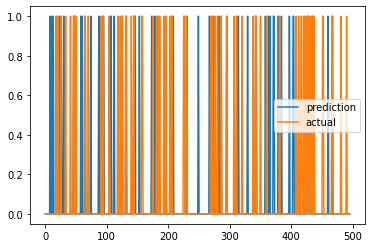

In [ ]:
plt_range = (0, len(res))
plt.plot(list(range(plt_range[1]-plt_range[0])), np.round(res[plt_range[0]: plt_range[1]]), label="prediction")
plt.plot(list(range(plt_range[1]-plt_range[0])), flat_highlights[plt_range[0]: plt_range[1]], label="actual")
plt.legend()
plt.show()

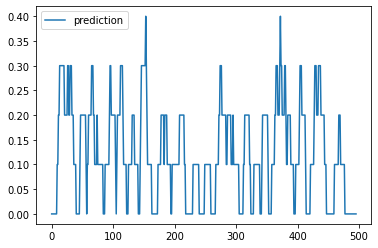

In [ ]:
plt.plot(list(range(plt_range[1]-plt_range[0])), moving_avg(np.round(res[plt_range[0]: plt_range[1]]), N=10), label="prediction")
# plt.plot(list(range(plt_range[1]-plt_range[0])), msg_dens_flat[plt_range[0]: plt_range[1]], label="message_density")
plt.legend()
plt.show()

In [ ]:
original_text = tokenizer.batch_decode(input_ids)

In [ ]:
original_text[plt_range[0]: plt_range[1]]

['<s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s>DARDOCH TRYIN HIS BEST TO IMPRESS PEANUT</s><s></s><s>"wtf who fed zed"</s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s>2</s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s>',
 '<s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s>Pooper StinkyCheese GarbageMandian DatSheffy EUsuxxen ANELE Keith McFeed FailFish Gate NotLikeThis</s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s>Froggen Eggs',
 '<s></s><s></s><s></s><s></s><s></s><s></s><s></s><s></s><s

In [ ]:
precision_recall_fscore_support(np.round(res).reshape(-1, 1), np.asarray(flat_highlights[:-5]).reshape(-1,1), average=None, pos_label=1)

(array([0.91571396, 0.37817704]),
 array([0.9248419 , 0.34936442]),
 array([0.92025529, 0.3632002 ]),
 array([94401, 12351]))

In [ ]:
accuracy_score(np.round(res).reshape(-1, 1), np.asarray(flat_highlights[:-5]).reshape(-1,1))

0.8582602667865707

In [ ]:
sum(flat_highlights)

In [ ]:
list(enumerate(zip(np.round(res).reshape(-1, 1), np.asarray(flat_highlights[:-2]).reshape(-1,1))))

[(0, (array([-0.]), array([0.]))),
 (1, (array([-0.]), array([0.]))),
 (2, (array([0.]), array([0.]))),
 (3, (array([-0.]), array([0.]))),
 (4, (array([-0.]), array([0.]))),
 (5, (array([-0.]), array([0.]))),
 (6, (array([-0.]), array([0.]))),
 (7, (array([0.]), array([0.]))),
 (8, (array([0.]), array([0.]))),
 (9, (array([0.]), array([0.]))),
 (10, (array([-0.]), array([0.]))),
 (11, (array([0.]), array([0.]))),
 (12, (array([-0.]), array([0.]))),
 (13, (array([0.]), array([0.]))),
 (14, (array([-0.]), array([0.]))),
 (15, (array([-0.]), array([0.]))),
 (16, (array([-0.]), array([0.]))),
 (17, (array([-0.]), array([0.]))),
 (18, (array([0.]), array([1.]))),
 (19, (array([-0.]), array([0.]))),
 (20, (array([1.]), array([1.]))),
 (21, (array([0.]), array([0.]))),
 (22, (array([-0.]), array([0.]))),
 (23, (array([1.]), array([0.]))),
 (24, (array([-0.]), array([0.]))),
 (25, (array([1.]), array([1.]))),
 (26, (array([1.]), array([0.]))),
 (27, (array([-0.]), array([0.]))),
 (28, (array([

## load training log



In [ ]:
with open("./LMPlusTemporal/runs/Jun17_15-14-00_a5cdc07ed73a/log_history.json") # choose directory for most recent successful run
json.load()